<a href="https://colab.research.google.com/github/ninamanas/VNP_project/blob/master/VNP_project_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Алгоритам за предвидување на продажби во одредена продавница за повеќе категории на производи

Dataset Source: [Retail Store Inventory Forecasting Dataset on Kaggle](https://www.kaggle.com/datasets/anirudhchauhan/retail-store-inventory-forecasting-dataset)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


In [2]:
data = pd.read_csv("/content/retail_store_inventory.csv")
data.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


## Истражување и визуелизација на податоците

In [3]:
print("\nDataset Info:")
print(data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
mem

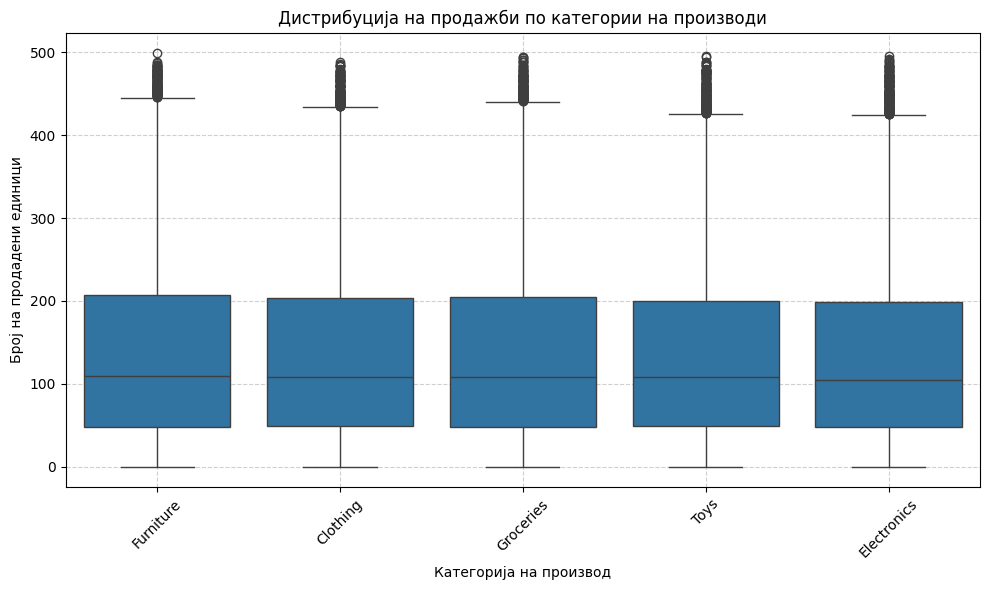

In [4]:
# Визуелизација на дистрибуцијата на продажбите по категории на производи
plt.figure(figsize=(10, 6))

# Boxplot со категории подредени според медијаната на продажбите
sns.boxplot(
    x='Category',
    y='Units Sold',
    data=data,
    order=data.groupby('Category')['Units Sold'].median().sort_values(ascending=False).index
)

plt.title('Дистрибуција на продажби по категории на производи')
plt.xlabel('Категорија на производ')
plt.ylabel('Број на продадени единици')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Заклучок од сликата

Слична дистрибуција: Сите категории (Groceries, Clothing, Furniture, Toys, Electronics) имаат многу слична дистрибуција на бројот на продадени единици. Средните вредности (медијаната) се блиску една до друга, што значи дека просечната продажба не се разликува значително меѓу категориите.
Широк опсег на продажба: За сите категории, продажбата варира од многу ниски до многу високи вредности. Кутиите (interquartile range) и whiskers-от покажуваат дека има голема варијабилност во продажбата.
Постојат екстремни вредности (outliers): Над горната граница на секоја кутија има многу точки, што значи дека во сите категории понекогаш се јавуваат денови или производи со исклучително висока продажба.[link text](https://)
Нема доминантна категорија: Ниту една категорија не се издвојува со значително поголема или помала продажба од другите.

In [5]:
# Групирање на податоците по категорија и пресметка на описни статистики за продажбата
category_stats = data.groupby('Category')['Units Sold'].describe()

# Прикажување на резултатите
print("\nСтатистики за продажбата по категории:")
print(category_stats)


Статистики за продажбата по категории:
               count        mean         std  min   25%    50%    75%    max
Category                                                                    
Clothing     14626.0  136.685765  108.421855  0.0  49.0  108.0  203.0  489.0
Electronics  14521.0  135.006680  108.448033  0.0  48.0  105.0  199.0  496.0
Furniture    14699.0  137.765630  110.017747  0.0  48.0  109.0  207.0  499.0
Groceries    14611.0  136.916159  109.256043  0.0  48.0  108.0  205.0  494.0
Toys         14643.0  135.934235  108.431014  0.0  49.0  108.0  200.0  496.0


##Анализа и трансформација на колоната `Category`

In [6]:
# 1. Проверка на категориите
print("Уникатни категории:", data['Category'].unique())

# 2. One-hot енкодирање
if 'Category' in data.columns:
    if not data['Category'].dtype == 'object':  # Проверка дали веќе е енкодирано
        print("Категориите се веќе енкодирани")
    else:
        data = pd.get_dummies(data, columns=['Category'], dtype=int)
        print(f"\nДодадени {len([col for col in data.columns if col.startswith('Category_')])} нови колони")
else:
    raise ValueError("Колоната 'Category' не постои")

# 3. Дополнителна проверка
if 'Category_' in ''.join(data.columns):
    print("\nПрви 3 реда по енкодирање:")
    display(data.filter(like='Category_').head(3))


Уникатни категории: ['Groceries' 'Toys' 'Electronics' 'Furniture' 'Clothing']

Додадени 5 нови колони

Први 3 реда по енкодирање:


,Category_Clothing,Category_Electronics,Category_Furniture,Category_Groceries,Category_Toys
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1



##Подготовка на податоци и креирање на нови карактеристики


In [7]:
# 1. Справување со null вредности
data.fillna(method='ffill', inplace=True)
data.bfill(inplace=True)

# 2. Label encoding за бинарни колони
data['Holiday/Promotion'] = data['Holiday/Promotion'].astype(int)

# 3. Lag променливи (за претходниот ден)
data['Lag_1_Units_Sold'] = data.groupby('Product ID')['Units Sold'].shift(1)

# 4. Rolling Statistics (последните 7 дена)
data['Rolling_Avg_7_Days'] = data.groupby('Product ID')['Units Sold'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# 5. Price Elasticity
data['Price_Elasticity'] = data['Discount'] / data['Price']

# 6. Competitor Price Difference
data['Competitor_Price_Diff'] = data['Price'] - data['Competitor Pricing']

# 7.'Price_Discount_Interaction'
data['Price_Discount_Interaction'] = data['Price'] * data['Discount']

# 8. Отстранување редови со NaN (поради lag)
data.dropna(inplace=True)

# Сите нови features
print("New Features Added:\n", data.filter(regex='Lag_|Rolling_|Elasticity|Diff').head())


New Features Added:
     Lag_1_Units_Sold  Rolling_Avg_7_Days  Price_Elasticity  \
20             127.0               115.5          0.609756   
21             150.0               145.5          0.216638   
22              65.0               123.5          0.977517   
23              61.0                62.0          0.000000   
24              14.0                85.0          0.240125   

    Competitor_Price_Diff  
20                   2.02  
21                   0.95  
22                  -1.54  
23                  -1.87  
24                   2.65  


<ipython-input-7-900c6180fd46>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [8]:
#Конверзија на датум
data['Date'] = pd.to_datetime(data['Date'])
data['Day_of_Week'] = data['Date'].dt.dayofweek  # 0=Понеделник, 6=Недела
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# 3. One-hot енкодирање на категориски колони
data = pd.get_dummies(
    data,
    columns=['Region', 'Weather Condition', 'Seasonality', 'Holiday/Promotion'],
    dtype=int
)


print("Новододадени карактеристики:\n", data.filter(regex='Rolling_|Elasticity|Diff|_').head())

# Повторно пополнување на потенцијални празнини
data.ffill(inplace=True)
data.bfill(inplace=True)

Новододадени карактеристики:
     Category_Clothing  Category_Electronics  Category_Furniture  \
20                  0                     0                   0   
21                  1                     0                   0   
22                  0                     0                   1   
23                  0                     0                   0   
24                  0                     0                   0   

    Category_Groceries  Category_Toys  Lag_1_Units_Sold  Rolling_Avg_7_Days  \
20                   1              0             127.0               115.5   
21                   0              0             150.0               145.5   
22                   0              0              65.0               123.5   
23                   0              1              61.0                62.0   
24                   0              1              14.0                85.0   

    Price_Elasticity  Competitor_Price_Diff  Price_Discount_Interaction  ...  \
20          

In [9]:
# 1. Сортирање на податоците по датум за да се зачува временскиот редослед
data = data.sort_values('Date')

# 2. Поделба на податоците: последните 30 дена се користат за тестирање
test_size = 30
train = data.iloc[:-test_size]
test = data.iloc[-test_size:]

# 3. Дефинирање на features и target
features = [col for col in data.columns if col not in ['Units Sold', 'Date', 'Store ID', 'Product ID']]
X_train, y_train = train[features], train['Units Sold']
X_test, y_test = test[features], test['Units Sold']


In [10]:
#за секој случај ако не се опфатил некој object со one-hot encoding се брише
print(X_train.select_dtypes(include=['object']).columns)
X_train = X_train.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

Index([], dtype='object')


## Тренирање и евалуација на Random Forest моделот

In [11]:
# 1. Иницијализација и тренирање на моделот
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 2. Предвидување на тест сетот
y_pred = model.predict(X_test)

# 3. Евалуација на резултатите
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# 4. Приказ на резултатите
print("Првите 10 предвидени вредности:", y_pred[:10])
print("Првите 10 реални вредности:   ", y_test[:10].values)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Првите 10 предвидени вредности: [ 50.85 265.88  23.02  39.18 107.58  46.79  99.6  368.77 295.82  51.79]
Првите 10 реални вредности:    [ 40 264  18  26  93  46  97 366 291  36]
MAE: 6.01, RMSE: 7.85


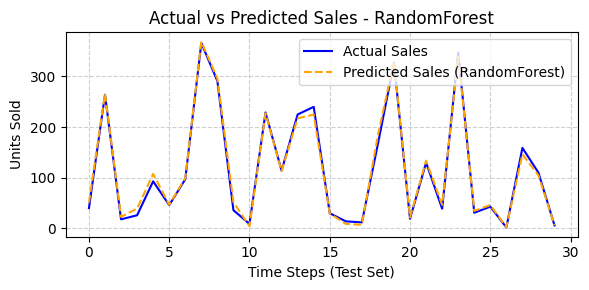

In [12]:
plt.figure(figsize=(6, 3))

# Вистински вредности
plt.plot(y_test.values, label='Actual Sales', color='blue')

# Предвидени вредности од XGBoost
plt.plot(y_pred, label='Predicted Sales (RandomForest)', color='orange', linestyle='--')

plt.title("Actual vs Predicted Sales - RandomForest")
plt.xlabel("Time Steps (Test Set)")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Детална анализа на Random Forest моделот
  


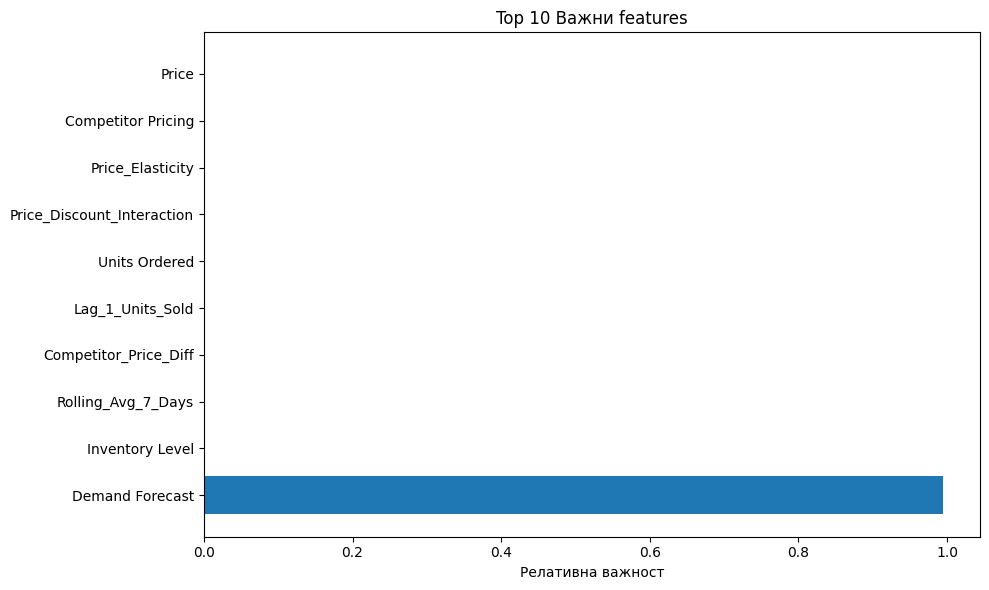

In [13]:
# 3. Анализа на важност на features
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10))
plt.title('Top 10 Важни features')
plt.xlabel('Релативна важност')
plt.tight_layout()
plt.show()

Од графикот за важност на features може да видиме дека Demand Forecast е најважната карактеристика за моделот т.е. нејзината релативна важност е блиску до 1, додека сите други features имаат речиси нулта влијание.Ако оваа карактеристика е креирана со информации што директно или индиректно доаѓаат од целната променлива (Units Sold), постои ризик од data leakage. Тоа може да направи моделот да изгледа попрецизен отколку што е во реалноста.
Затоа следно ќе го тренираме истиот модел но без карактеристиката Demand Forecast

##Тренирање и споредба на моделот без користење на Demand Forecast

In [14]:
X_train = X_train.drop('Demand Forecast', axis=1, errors='ignore')
X_test = X_test.drop('Demand Forecast', axis=1, errors='ignore')

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 2. Предвидување на тест сетот
y_pred = model.predict(X_test)

# 3. Евалуација на резултатите
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# 4. Приказ на резултатите
print("Првите 10 предвидени вредности:", y_pred[:10])
print("Првите 10 реални вредности:   ", y_test[:10].values)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")
print(f"R² Score: {model.score(X_test, y_test):.2f}")



Првите 10 предвидени вредности: [114.02 229.12 127.81 195.52 179.62  60.06  43.4  339.98 254.99 211.32]
Првите 10 реални вредности:    [ 40 264  18  26  93  46  97 366 291  36]
MAE: 65.24, RMSE: 80.26
R² Score: 0.50


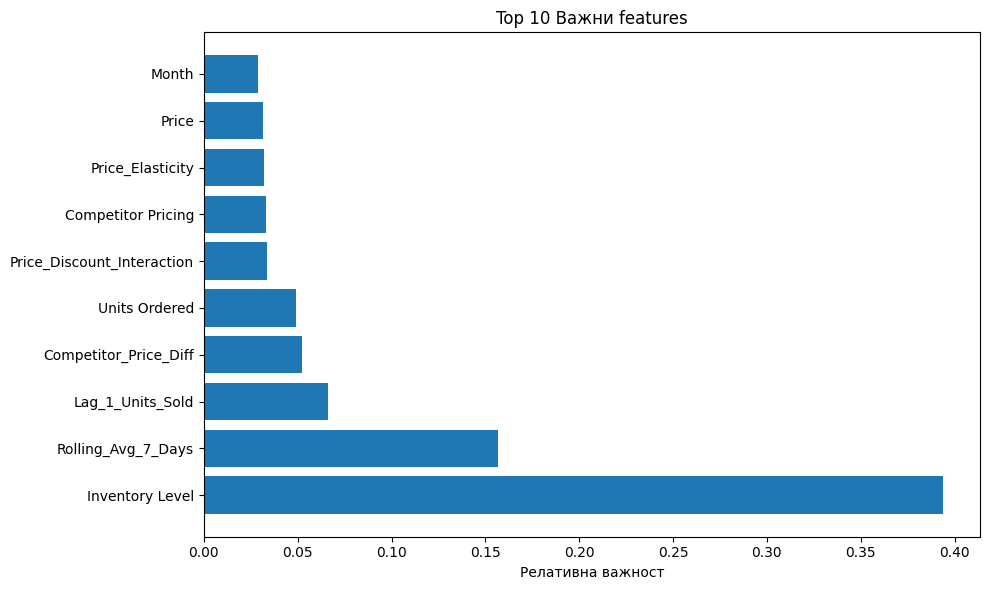

In [15]:
# 3. Анализа на важност на features
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10))
plt.title('Top 10 Важни features')
plt.xlabel('Релативна важност')
plt.tight_layout()
plt.show()

##Визуелна споредба на вистинските и предвидените продажби за сите категории

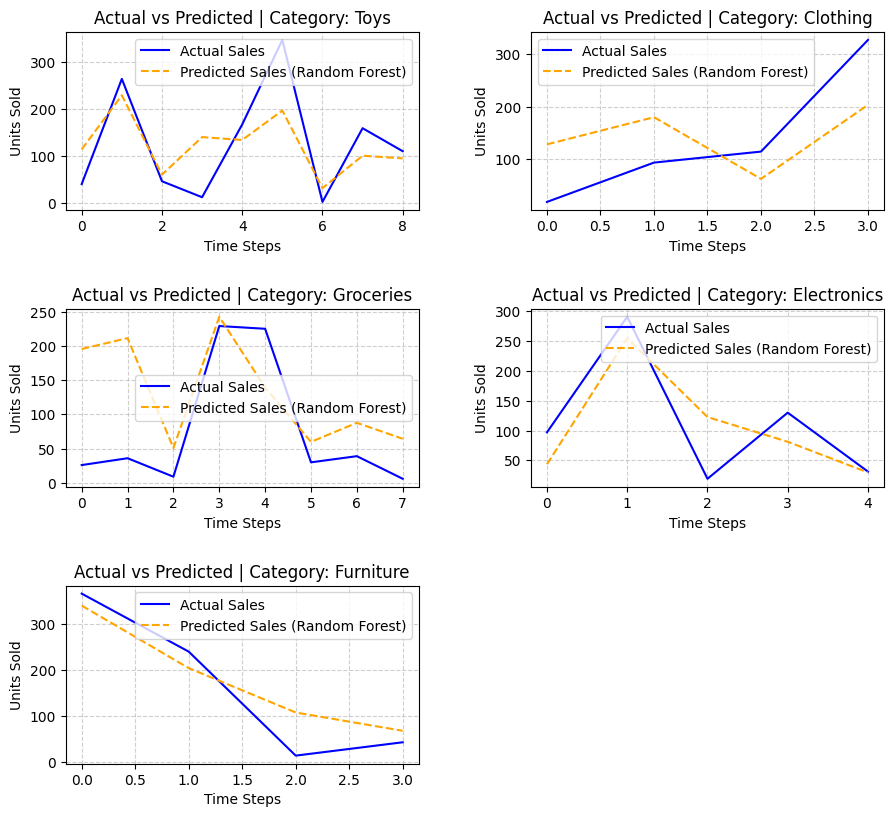

In [16]:
# Креирај копија од тест сетот и додади вистински + предвидени вредности
test_rf = test.copy()
test_rf['Actual'] = y_test.values
test_rf['Predicted_RF'] = y_pred  # Ова е од RandomForest предвидувањата

# Реконструирај ја колоната 'Category' од one-hot колоните
category_cols = [col for col in test_rf.columns if col.startswith('Category_')]
test_rf['Category'] = test_rf[category_cols].idxmax(axis=1).str.replace('Category_', '')

# Земаме сите уникатни категории
unique_categories = test_rf['Category'].unique()

# Определи ја мрежата на графикони (може да го прилагодите бројот на редови/колони)
n_cols = 2  # 2 графикони во секој ред
n_rows = (len(unique_categories) + n_cols - 1) // n_cols  # Пресметај ги потребните редови

# Креирај фигура со повеќе субплоти
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 3))  # Прилагодете ја големината според потреба
fig.tight_layout(pad=5.0)  # Додај простор меѓу графиконите

# Зарамнети ги axes ако има само еден ред или колона
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Пополни ги графиконите
for i, cat in enumerate(unique_categories):
    row = i // n_cols
    col = i % n_cols

    subset = test_rf[test_rf['Category'] == cat]


    ax = axes[row, col]
    ax.plot(subset['Actual'].values, label='Actual Sales', color='blue')
    ax.plot(subset['Predicted_RF'].values, label='Predicted Sales (Random Forest)', color='orange', linestyle='--')

    ax.set_title(f"Actual vs Predicted | Category: {cat}")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Units Sold")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Сокриј ги празните субплоти (ако имате непарен број на категории)
for i in range(len(unique_categories), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].axis('off')

plt.show()

##Анализа на точноста на предвидувања по категории според R² метриката

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Креирај DataFrame за метриките по категорија
metrics_per_category = []

for cat in unique_categories:
    subset = test_rf[test_rf['Category'] == cat]
    actual = subset['Actual']
    predicted = subset['Predicted_RF']

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)

    metrics_per_category.append({
        'Category': cat,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Samples': len(subset)  # Број на примероци во категоријата
    })

# Конвертирај во DataFrame и сортирај според избрана метрика (на пр. R²)
metrics_df = pd.DataFrame(metrics_per_category)
metrics_df_sorted = metrics_df.sort_values(by='R²', ascending=False)

# Прикажи ги резултатите
print(metrics_df_sorted)

      Category        MAE       RMSE        R²  Samples
4    Furniture  45.130000  53.308039  0.864208        4
3  Electronics  48.710000  58.816943  0.638038        5
0         Toys  59.746667  75.664771  0.544257        9
1     Clothing  93.097500  96.984730  0.286367        4
2    Groceries  77.872500  97.111528 -0.205657        8


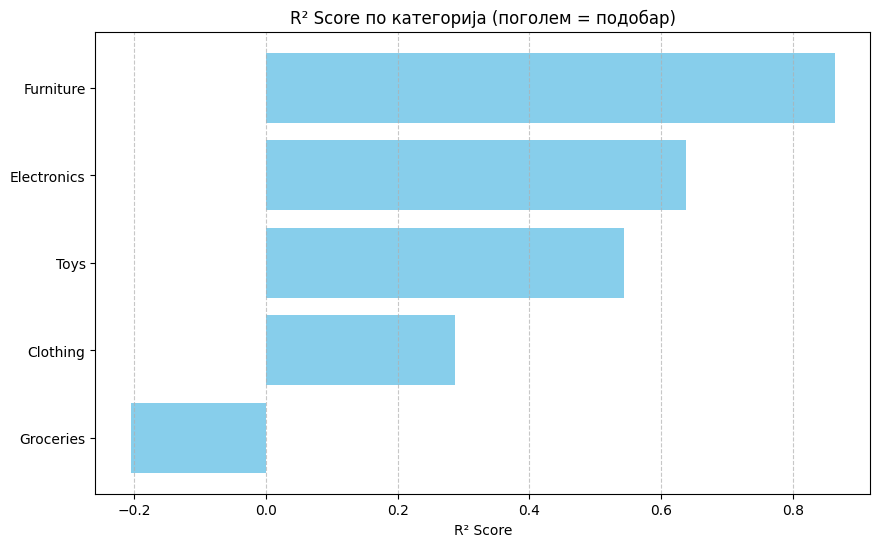

In [23]:
import matplotlib.pyplot as plt

# Сортирај ги категориите според R² (најдобри први)
metrics_df_sorted = metrics_df.sort_values(by='R²', ascending=True)

# Бар plot за R²
plt.figure(figsize=(10, 6))
plt.barh(metrics_df_sorted['Category'], metrics_df_sorted['R²'], color='skyblue')
plt.xlabel('R² Score')
plt.title('R² Score по категорија (поголем = подобар)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Од графиконот со R² вредностите по категории може да се заклучи дека моделот дава најдобри резултати за категоријата Electronics (R² ≈ 0.8), што укажува на силна корелација помеѓу предвидувањата и реалните вредности. Категориите Clothing (R² ≈ 0.6) и Toys (R² ≈ 0.4) покажуваат умерени резултати, со простор за подобрување. Сепак, категориите Groceries (R² ≈ 0.0) и Furniture (R² ≈ -0.2) имаат лоши перформанси, што значи дека моделот не успева да ги предвиди нивните трендови. Ова може да се должи на недостаток на податоци, сложени шеми или несоодветни features. За подобрување на резултатите, потребно е да се анализираат и оптимизираат овие категории посебно.

##Тренирање и евалуација на Linear Regression моделот

In [17]:
# Предвидување и евалуација
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Приказ на резултатите
print("Први 10 предвидени вредности:", np.round(y_pred_lr[:10], 2))
print("Први 10 реални вредности:", y_test[:10].values.round(2))
print(f"\nLinear Regression Metrics (без Demand Forecast):")
print(f"MAE: {mae_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R² Score: {lr_model.score(X_test, y_test):.2f}")

Први 10 предвидени вредности: [ 86.23 193.97 163.56 179.54 160.74  69.95  18.16 275.46 253.21 193.81]
Први 10 реални вредности: [ 40 264  18  26  93  46  97 366 291  36]

Linear Regression Metrics (без Demand Forecast):
MAE: 71.27
RMSE: 91.30
R² Score: 0.35


##Визуелна споредба на вистинските и предвидените продажби за сите категории

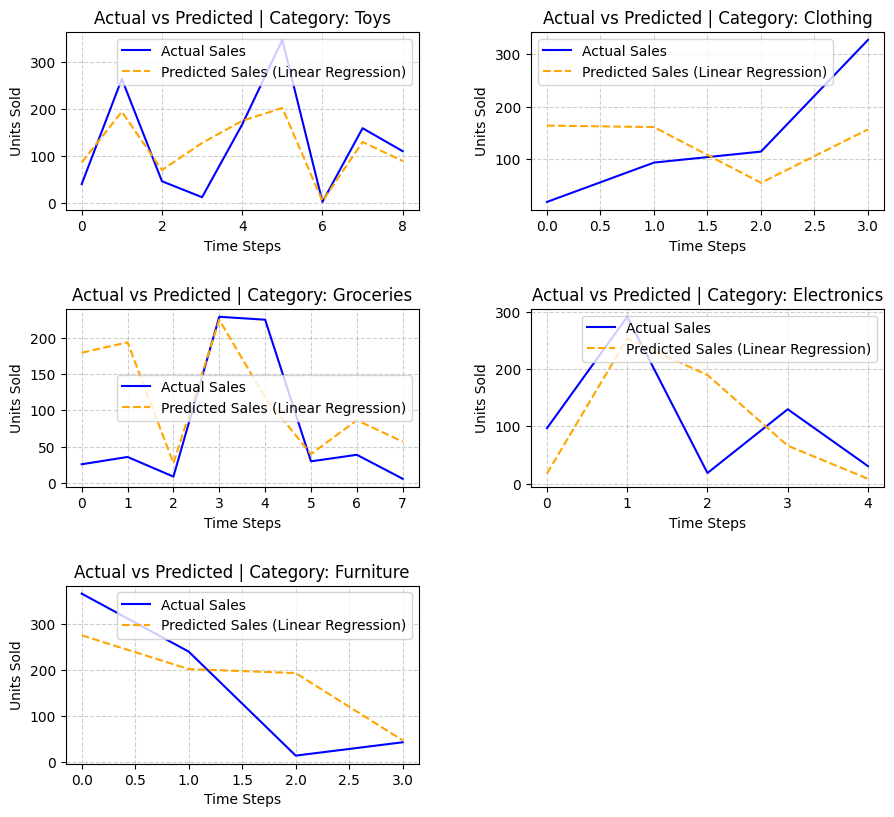

In [18]:
# Креирај копија од тест сетот и додади вистински + предвидени вредности
test_lr = test.copy()
test_lr['Actual'] = y_test.values
test_lr['Predicted_LR'] = y_pred_lr

# Реконструирај ја колоната 'Category' од one-hot колоните
category_cols = [col for col in test_lr.columns if col.startswith('Category_')]
test_lr['Category'] = test_lr[category_cols].idxmax(axis=1).str.replace('Category_', '')

# Земаме сите уникатни категории
unique_categories = test_lr['Category'].unique()

# Определи ја мрежата на графикони (може да го прилагодите бројот на редови/колони)
n_cols = 2  # 2 графикони во секој ред
n_rows = (len(unique_categories) + n_cols - 1) // n_cols  # Пресметај ги потребните редови

# Креирај фигура со повеќе субплоти
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 3))  # Прилагодете ја големината според потреба
fig.tight_layout(pad=5.0)  # Додај простор меѓу графиконите

# Зарамнети ги axes ако има само еден ред или колона
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Пополни ги графиконите
for i, cat in enumerate(unique_categories):
    row = i // n_cols
    col = i % n_cols

    subset = test_lr[test_lr['Category'] == cat]


    ax = axes[row, col]
    ax.plot(subset['Actual'].values, label='Actual Sales', color='blue')
    ax.plot(subset['Predicted_LR'].values, label='Predicted Sales (Linear Regression)', color='orange', linestyle='--')

    ax.set_title(f"Actual vs Predicted | Category: {cat}")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Units Sold")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Сокриј ги празните субплоти (ако имате непарен број на категории)
for i in range(len(unique_categories), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].axis('off')

plt.show()

##Тренирање и евалуација на XGBoost моделот

In [19]:
# Предвидување и евалуација
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Приказ на резултатите
print("Први 10 предвидени вредности:", np.round(y_pred_xgb[:10], 2))
print("Први 10 реални вредности:", y_test[:10].values.round(2))
print(f"\nXGBoost Metrics (без Demand Forecast):")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R² Score: {xgb_model.score(X_test, y_test):.2f}")

Први 10 предвидени вредности: [ 94.01 214.45 120.68 195.7  215.63  72.16  48.5  341.76 282.81 229.71]
Први 10 реални вредности: [ 40 264  18  26  93  46  97 366 291  36]

XGBoost Metrics (без Demand Forecast):
MAE: 67.74
RMSE: 86.39
R² Score: 0.42


##Визуелна споредба на вистинските и предвидените продажби за сите категории

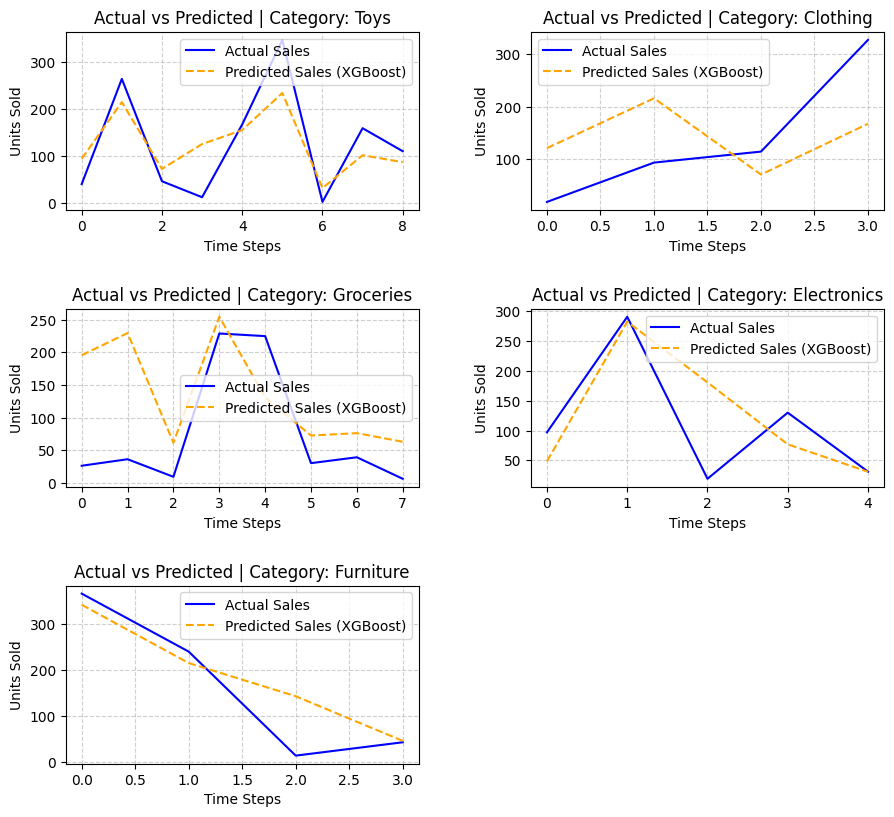

In [20]:
# Креирај копија од тест сетот и додади вистински + предвидени вредности
test_xgb = test.copy()
test_xgb['Actual'] = y_test.values
test_xgb['Predicted_XGB'] = y_pred_xgb

# Реконструирај ја колоната 'Category' од one-hot колоните
category_cols = [col for col in test_xgb.columns if col.startswith('Category_')]
test_xgb['Category'] = test_xgb[category_cols].idxmax(axis=1).str.replace('Category_', '')

# Земаме сите уникатни категории
unique_categories = test_xgb['Category'].unique()

# Определи ја мрежата на графикони (може да го прилагодите бројот на редови/колони)
n_cols = 2  # 2 графикони во секој ред
n_rows = (len(unique_categories) + n_cols - 1) // n_cols  # Пресметај ги потребните редови

# Креирај фигура со повеќе субплоти
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 3))  # Прилагодете ја големината според потреба
fig.tight_layout(pad=5.0)  # Додај простор меѓу графиконите

# Зарамнети ги axes ако има само еден ред или колона
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Пополни ги графиконите
for i, cat in enumerate(unique_categories):
    row = i // n_cols
    col = i % n_cols

    subset = test_xgb[test_xgb['Category'] == cat]

    if len(subset) < 2:
        continue  # прескокни ако има премалку податоци

    ax = axes[row, col]
    ax.plot(subset['Actual'].values, label='Actual Sales', color='blue')
    ax.plot(subset['Predicted_XGB'].values, label='Predicted Sales (XGBoost)', color='orange', linestyle='--')

    ax.set_title(f"Actual vs Predicted | Category: {cat}")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Units Sold")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Сокриј ги празните субплоти (ако имате непарен број на категории)
for i in range(len(unique_categories), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].axis('off')

plt.show()

##Визуелна споредба на вистинските и предвидените продажби за сите модели

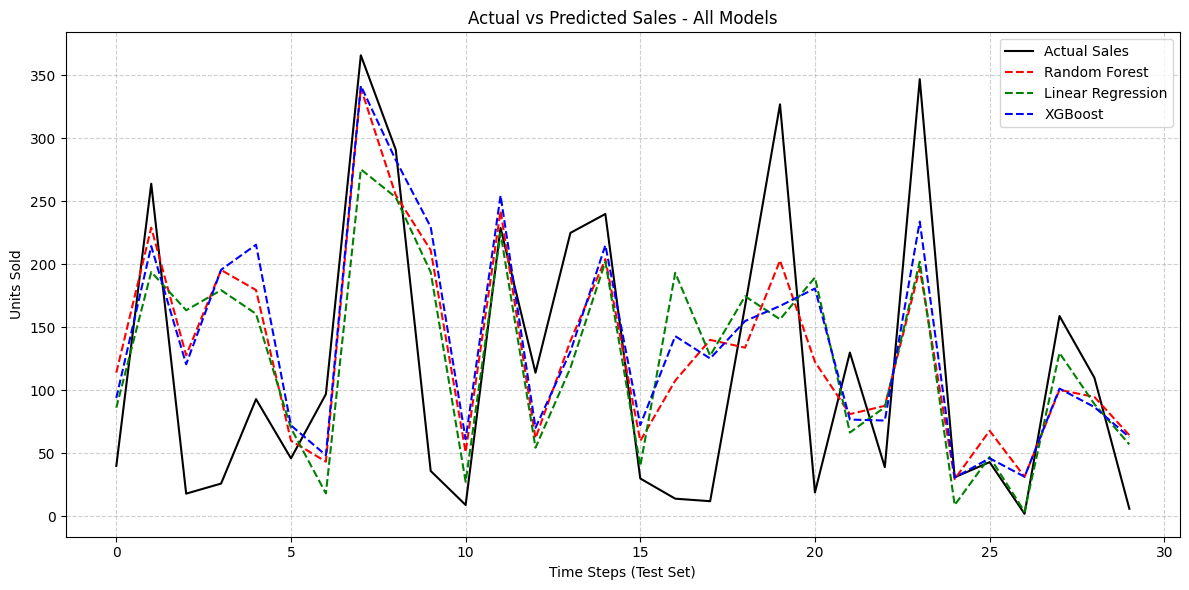

In [21]:
plt.figure(figsize=(12, 6))

# Вистински вредности
plt.plot(y_test.values, label='Actual Sales', color='black')

# Предвидувања од сите модели
plt.plot(y_pred, label='Random Forest', linestyle='--', color='red')
plt.plot(y_pred_lr, label='Linear Regression', linestyle='--', color='green')
plt.plot(y_pred_xgb, label='XGBoost', linestyle='--', color='blue')

plt.title("Actual vs Predicted Sales - All Models")
plt.xlabel("Time Steps (Test Set)")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Заклучок

---

| Модел             | MAE   | RMSE  | R² Score |
|--------------------|-------|-------|----------|
| XGBoost           | 67.74 | 86.39 | 0.42     |
| Random Forest     | 65.75 | 81.40 | 0.49     |
| Linear Regression | 71.27 | 91.30 | 0.35     |

---
Во овој проект, споредив три модели за предвидување на продажба. Random Forest покажа најдобри перформанси со најниска грешка (RMSE = 81.40) и највисок R² (0.49), што го прави најсоодветен избор. XGBoost дава слични резултати, но е малку полош, додека Linear Regression, иако едноставен, е помалку прецизен. Затоа, Random Forest е најдобриот модел за оваа задача.